In [1]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
import shapely
from shapely.geometry import *
import shutil

sys.path.append("../../modules")
# hand made functions
from Rouss import *
from Rouss3D import *
from Utility_inv import *

sys.path.append("../../Model_val/upscalling/")
from upscalling_functions import *

flopy is installed in C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\flopy


In [2]:
model_dir = "workspace"
model_name = "pest_3D_R"
exe_name="../../exe/mf6"

In [3]:
############# set every external variables (bcs and spatial parameters)

MNT_path="../../data/surfaces_geoter_decoup/TOPO (inf 0 en mer).asc"
Agly_path= "../../data/Fleuves/Agly_ludo.shp" # path to Agly
Tet_path= "../../data/Fleuves/Tet_ludo.shp"
Rea_path = "../../data/Fleuves/Reart_ludo.shp"
Tech_path = "../../data/Fleuves/Tech_ludo.shp"
Bol_path = "../../data/Fleuves/Boules_ludo.shp"
Cant_path = "../../data/Fleuves/Cant_ludo.shp"


#stations paths
Agly_stations = "../../data/Fleuves/stations_agly.csv" 
Tet_stations = "../../data/Fleuves/stations_tet2.csv"
Rea_stations = "../../data/Fleuves/stations_reart.csv"
Tech_stations = "../../data/Fleuves/stations_tech.csv"
Bol_stations = "../../data/Fleuves/stations_bol.csv"
Cant_stations = "../../data/Fleuves/stations_cant.csv"


top,botm,idomain,delr,delc = read_pickle("workspace/export_dis3D") # import data from the DIS notebook

### spatial parameters
x0,x1,y0,y1 = Raster.load(MNT_path).bounds

ncol = idomain.shape[2]
nrow = idomain.shape[1]
nlay = idomain.shape[0]

## initialize flopy grid for intersection
grid = fp.discretization.StructuredGrid(delc,delr,xoff=x0,yoff=y0) # create a grid identical to the dis package, will be used
                                                                   # to pre-process data
ix = GridIntersect(grid)

# Do a list of all active cells
lst_domain = []
for ilay in range(nlay):
    for irow in range(nrow):
        for icol in range(ncol):
            if idomain[ilay,irow,icol] == 1:
                lst_domain.append((ilay,irow,icol))
                
#uppermost active cell
Up_cells_act = up_act_cell(idomain)


### BC sea
# import the shapefile that correspond to the BC
BCsea_path = "../../data/shp/sea_bc_extended.shp"
BC_sea = gp.read_file(BCsea_path)

# extract cellids from the BC at the sea and make these cells active
lst_chd = gp2cellids3D(grid,BC_sea,idomain,type="polygon",idomain_active=True,layer=0)

# attribute a constant head at all the cells in the lst_chd
chd_lst=[];chd_min=0.1
for x in lst_chd:
    chd_v = -0.025*top[x[1],x[2]] #equivalent freshwater head
    if chd_v < 0:
        chd_v = chd_min
    chd_lst.append((x,chd_v))
    chd_va=chd_v
    #chd_lst.append((x,0.1))
###
    
### BC Etangs
BCetangs_path = "../../data/shp/Surface_hydro/SURFACE_HYDROGRAPHIQUE.shp"
Bcet = gp.read_file(BCetangs_path)
etangs = Bcet[(Bcet["TOPONYME"]=="étang de canet") | (Bcet["TOPONYME"]=="étang de leucate")]

# extract cellids from the BC 
etangs_chd = gp2cellids3D(grid,etangs.dissolve(by="NATURE"),idomain,idomain_active=True,layer=1)

# attribute a constant head
elev = 0.1; et_drn_lst=[];
for x in etangs_chd:
    et_drn_lst.append((x,elev,1))
###
  
### Rivers
#import
Agy_chd = Complete_riv(Agly_path,Agly_stations,28,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Tech_chd = Complete_riv(Tech_path,Tech_stations,180,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Cant_chd = Complete_riv(Cant_path,Cant_stations,140,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Rea_chd = Complete_riv(Rea_path,Rea_stations,100,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Tet_chd = Complete_riv(Tet_path,Tet_stations,180,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Bol_chd = Complete_riv(Bol_path,Bol_stations,180,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)

#from chd to riv
lst_riv_chd=[Agy_chd,Tech_chd,Cant_chd,Rea_chd,Tet_chd,Bol_chd]
cond = [0.005,0.005,0.005,0.005,0.005,0.005]

for iriv in range(len(lst_riv_chd)):
    chd2riv(lst_riv_chd[iriv],cond[iriv],2)
###

### Prelevements
geol_col = "NAPPE_CAPT" # name of lithology column
v_col = "VOL_2013" # name of the volume column
path = "../../data/prélèvements/donnees_sandra/SynthèseSLanini_data_Prelevements_1987-2018.shp" # path to shp
BD = gp.read_file(path)

#remove points with no geometry info
for i in range(BD.shape[0]):
    if BD.geometry[i]==None:
        BD.drop(i,axis=0,inplace=True)
BD  = BD[BD["USAGES"]!="IRRIGATION"] # drop irrigation
stress_data_well = importWells3D(BD,grid,lst_domain,fac=1/365/86400,V_col=v_col, geol_col=geol_col,
                                 geol_layer=["PLIOCENE","QUATERNAIRE","INDETERMINE"],layer_num=[[3,4],1,[1,3,4]])
###

### P agri
path_Q = "../../data/prélèvements/prlvm_agri_Q.asc"
path_P = "../../data/prélèvements/prlvm_agri_P.asc"
p_agri_Q = rspl_rast(path_Q,grid)
p_agri_P = rspl_rast(path_P,grid)

# make a list for rch package
## PQ
p_agr=[]
for icell in Up_cells_act:
    irow = icell[1]
    icol = icell[2]
    if p_agri_Q[irow,icol] != 0:
        if (1,irow,icol) in lst_domain:
            p_agr.append(((1,irow,icol),p_agri_Q[irow,icol]/1000/365/86400))
    if p_agri_P[irow,icol] != 0:
        if (3,irow,icol) in lst_domain:
            p_agr.append(((3,irow,icol),p_agri_P[irow,icol]/1000/365/86400))
        else:
            if (4,irow,icol) in lst_domain:
                p_agr.append(((4,irow,icol),p_agri_P[irow,icol]/1000/365/86400))
        
###
# recharge
rch_path="../../data/recharge/recharge_p.tif"
rch = rspl_rast(rch_path,grid) # resample to grid
rch[rch<0]=np.mean(rch[rch>0]) # replace negative values by a mean

rch[np.abs(idomain).sum(0)==0]=0 # remove some rch
rch[idomain[0]==1]=0 # remove some rch
for cell in etangs_chd:
    rch[cell[1],cell[2]]=0
    
rch = liss_mob(rch,5) # moving average

# make a list for rch package
rch_lst=[]
for icell in Up_cells_act:
    irow = icell[1]
    icol = icell[2]
    if rch[irow,icol] > 0:
        rch_lst.append(((icell),rch[irow,icol]/1000/365/86400))
###

### recharge irrigation
irr_path = "../../data/recharge/rast_irr.asc"
irr = rspl_rast(irr_path,grid)
irr[irr<0]=0

#create list
irr_lst=[]
for icell in Up_cells_act:
    irow = icell[1]
    icol = icell[2]
    if irr[irow,icol] !=0:
        irr_lst.append(((icell),irr[irow,icol]/1000/365/86400))
###

### permeability
k = np.ones([nlay,nrow,ncol])*1e-4
k[0] = 1e-5
k[1] = 2e-3 # Q
k[2] = 0.25e-8 # interQ/PC
k[3] = 1e-5 #PC
k[4] = 1e-5 # PMS

#### BC Thuir
layer = [1,3]
poly = Polygon([(674e3,616.8e4),(674e3,617.4e4),(678e3,617.4e4),(678e3,616.8e4)]) #area
plio_chd = []

for layer in layer:
    BDcells = cellidBD(idomain,layer=layer) # boundary cells
    for cellid in ix.intersect_polygon(poly).cellids:
        cell = (layer,cellid[0],cellid[1])
        if cell in BDcells:
            if layer == 1:
                plio_chd.append((cell,140))
            if layer == 3:
                plio_chd.append((cell,115))
####

#### Corbières
layer = [3,4] # apply on which layers
Corb_lst = []
Corb_spd = []
flux = 0.2 #total flux
    
for layer in layer:
    BDcells = cellidBD(idomain,layer)
    poly = Polygon([(685e3,618.7e4),(685e3,619.5e4),(696e3,619.5e4),(696e3,618.7e4)])

    res = ix.intersect_polygon(poly)
    for cellid in res.cellids:
        cell = (layer,cellid[0],cellid[1])
        if cell in BDcells:
            Corb_lst.append(cell)
    n_cells = len(Corb_lst)

for cell in Corb_lst:
    Corb_spd.append((cell,flux/n_cells))

In [4]:
#create txt file for easy parametrization

#K  
np.savetxt(os.path.join(model_dir,"kqm.txt"),k[0])
np.savetxt(os.path.join(model_dir,"kq.txt"),k[1])
np.savetxt(os.path.join(model_dir,"kep.txt"),k[2])
np.savetxt(os.path.join(model_dir,"kpc.txt"),k[3])
np.savetxt(os.path.join(model_dir,"kpms.txt"),k[4])

#irr
np.savetxt(os.path.join(model_dir,"irr.txt"),irr/1000/365/86400)
list_val = np.unique(irr)[1:]
irr_z=irr
for i,ival in enumerate(list_val):
    irr_z[irr_z==ival]=i+1
np.savetxt(os.path.join(model_dir,"zone_irr.txt"),irr_z)

In [20]:
####### obs

# control piezos
piez_path="../../data/piezos/pz_hydriad.xlsx"

#import the data using ImportControlPz3D (path,modelgrid, sheetname of the data,piezometric level column, x and y coor (in L93 !))
geol_layer = ["Quaternaire","Pliocène"]
geol_col = "AquifèreCapté"
Control_Pz = ImportControlPz3D(piez_path,sheet_name="2012",geol_layer=geol_layer,layer_num=[1,3],geol_col=geol_col,
                               grid=grid,nlay=nlay,np_col = "NP_Avril2013")

il,ir,ic = np.where([Control_Pz!=0][0]) #indice where there's an observation

lst_pts_q=[]
lst_pts_p=[]
for o in range(il.shape[0]):
    cell = (il[o],ir[o],ic[o])
    if cell in lst_domain:
        if il[o] == 1:
            lst_pts_q.append((il[o],ir[o],ic[o]))
        if il[o] == 3:
            lst_pts_p.append((il[o],ir[o],ic[o]))

obs_lstq=[]
for pts in lst_pts_q:
    obs_lstq.append(("1_{}_{}".format(pts[1],pts[2]),"HEAD",pts))

obs_lstp=[]
for pts in lst_pts_p:
    obs_lstp.append(("3_{}_{}".format(pts[1],pts[2]),"HEAD",pts))
    
    
    
obs_recarray = {('heads_pc.csv'):obs_lstp,
                ('heads_q.csv'):obs_lstq}

C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\xlrd\xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [32]:
# basic modules
sim = fp.mf6.MFSimulation(sim_name='first3D_mf6', version='mf6', exe_name=exe_name, 
                         sim_ws=model_dir)
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,xorigin=x0,yorigin=y0,idomain=idomain)

tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=[[1.0, 1, 1.]])
ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity="simple")

# initial conditions
ic   = fp.mf6.ModflowGwfic(gwf,strt=botm+1)

# output control
oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            saverecord=[('HEAD', 'LAST'),
                                        ('BUDGET', 'LAST')],
                            printrecord=[('HEAD', 'LAST'),('BUDGET', 'ALL')])

# nodeflowproperty
npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=["kqm.txt","kq.txt","kep.txt","kpc.txt","kpms.txt"],save_flows=True)

#well
wel = fp.mf6.ModflowGwfwel(gwf,pname="wel",maxbound=len(stress_data_well),
                           stress_period_data=stress_data_well,save_flows=True)

# recharge
rch = fp.mf6.ModflowGwfrch(gwf,pname = "rch",maxbound=len(rch_lst),stress_period_data=rch_lst,save_flows=True)

# irrigation
irri = fp.mf6.ModflowGwfrcha(gwf,pname="irrig",filename="irri.rch",recharge="irr.txt",irch=2,save_flows=True)

p_ag = fp.mf6.ModflowGwfrch(gwf,pname="p_agri",filename="p_agri.rch",maxbound=len(p_agr),stress_period_data=p_agr,save_flows=True)


#Corbières
Corb = fp.mf6.ModflowGwfwel(gwf,pname="Corb",filename="Corb.wel",maxbound=len(Corb_spd),
                            stress_period_data=Corb_spd,save_flows=True)

#constant heads
chd = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='sea', filename="sea.chd", maxbound=len(chd_lst), 
                                               stress_period_data={0: chd_lst}, save_flows=True)

thuir = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='thuir', filename="thuir.chd", maxbound=len(plio_chd), 
                                                       stress_period_data={0: plio_chd}, save_flows=True)
#etangs
etangs = fp.mf6.modflow.mfgwfdrn.ModflowGwfdrn(gwf,pname="eta",filename="eta.drn",maxbound=len(et_drn_lst),
                                              stress_period_data=et_drn_lst,save_flows=True)

# Rivers
Agly = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf,pname="agly",filename="agly.riv",maxbound=len(Agy_chd),
                                                stress_period_data={0: Agy_chd}, save_flows=True)

Riv2 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Tet', filename="Tet.riv", maxbound=len(Tet_chd), 
                                               stress_period_data={0: Tet_chd}, save_flows=True)

Riv3 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Rea', filename="Rea.riv", maxbound=len(Rea_chd), 
                                               stress_period_data={0: Rea_chd}, save_flows=True)

Riv6 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Cant', filename="Cant.riv", maxbound=len(Cant_chd), 
                                               stress_period_data={0: Cant_chd}, save_flows=True)

Riv4 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Tech', filename="Tech.riv", maxbound=len(Tech_chd), 
                                               stress_period_data={0: Tech_chd}, save_flows=True)

Riv5 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Bol', filename="Bol.riv", maxbound=len(Bol_chd), 
                                               stress_period_data={0: Bol_chd}, save_flows=True)


obs_package = fp.mf6.ModflowUtlobs(gwf, pname='head_obs', filename='{}.obs'.format(model_name), 
                                      digits=10, print_input=True,
                                      continuous=obs_recarray)

In [33]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model pest_3D_R...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package wel...
    writing package rch...
    writing package irrig...
    writing package p_agri...
    writing package corb...
    writing package sea...
    writing package thuir...
    writing package eta...
    writing package agly...
    writing package tet...
    writing package rea...
    writing package cant...
    writing package tech...
    writing package bol...
    writing package head_obs...


In [23]:
# transform river package to import data from a txt file
rivfile = [file for file in os.listdir(model_dir) if file.endswith(".riv")]
rivname = [file.split(".")[0] for file in os.listdir(model_dir) if file.endswith(".riv")]

for rivnm,river in zip(rivname,rivfile):
    fname = os.path.join(model_dir,river)
    txt_file = os.path.join(model_dir,rivnm)+".txt"
    # pack2txt(fname,txt_file)

In [34]:
sim.run_simulation()

FloPy is using the following  executable to run the model: ../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources Soft

(True, [])

In [25]:
# change observations values to real observations values
file_to_change=["heads_q.csv","heads_pc.csv"]
layer_CPz=[1,3]

for fi,il in zip(file_to_change,layer_CPz):
    path_tmp = os.path.join(model_dir,"tmp")
    file_tmp = open(path_tmp,"w")
    with open(os.path.join(model_dir,fi)) as f:
        file_tmp.write(f.readlines()[0])
        file_tmp.write("1.0000000")
        if il == 1:
            for i,j,k in lst_pts_q:
                file_tmp.write("," + str(Control_Pz[il,j,k])) # observations from Control_pz replace obs from modflow
        if il == 3:
            for i,j,k in lst_pts_p:
                file_tmp.write("," + str(Control_Pz[il,j,k])) # observations from Control_pz replace obs from modflow
    file_tmp.close()

    #copy everything and save on head.csv
    from shutil import copyfile
    copyfile(path_tmp, os.path.join(model_dir,fi)) # copy 
    os.remove(path_tmp) # delete tmp file

In [26]:
head = get_heads(model_name,model_dir)

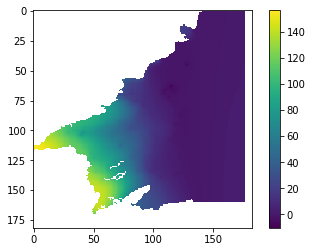

In [27]:
head[head>1000] = None 
plt.imshow(head[3])
plt.colorbar()